# Transformer Decoder Character Level Language Model

We are interested in creating a statistical language model: predict the probability of the next token (word/subword/character) given all of the previous tokens in the sequence. This task is typically used to train a general model as a starting point for training on other tasks. This is known as pre-training.

Before transformers, the state-of-the-art in neural sequence-to-sequence learning was recurrent neural networks (RNNs) with an encoder and decoder. Although RNNs have nice theoretical properties, in practice a vanilla RNN is very forgetful. For instance,  reversing the input so that the corresponding output is closer [improves performance significantly](https://arxiv.org/pdf/1409.3215.pdf). One solution to this forgetfulness is to introduce new connections, in the form of attention, between the encoder hidden states and the decoder which shorten the length of the paths information needs to flow. As attention mechanisms were developed it was natural to ask, do we need the RNN at all? In ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf) Vaswani et al. propose this idea and call the resulting model "transformers".

The transformer consists of two parts, the encoder and the decoder. For our language model, we will drop the encoder and keep the [transformer decoder](https://arxiv.org/pdf/1801.10198.pdf). Our input sequence is first embedded and summed with a positional embedding. This position embedding is required since we lose position information when applying attention. We then do go through $N$ layers of alternating masked multi-head self attention and feed forward neural network blocks. 

The attention mechanism performs the following operation for 3 input matrices of queries $Q$, keys $K$, and values $V$

$$\mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

where $d_k$ is a dimension parameter. Intuitively, this operation checks the closeness of the queries with the keys and uses this to produce a weighted sum of the values. The masked multi-head self attention block first does a linear mapping of the input to $Q$, $K$, and $V$ for each head and executes the attention operation. A mask is applied to the attention so that a token at position $i$ can only attend to tokens at positions $j\le i$. The output is then concatenated and another linear map is performed.
The feed forward network block is a standard 1 layer feed forward neural network applied identically to the input at each position.

The final output is then passed through a linear transformation and softmax to predict the probabilities of the next token for each position. We can train the entire network with [Adam](https://arxiv.org/abs/1412.6980) on the cross entropy loss.

## Overview

We will first prepare the "Yelp Review Polarity" dataset, and then implement and train a transformer decoder language model at the character level on this dataset. We will then examine reviews sampled from the model and visualize the attention in the last layer.

## The Experiment
We will begin by downloading the dataset. The dataset was generated in 2015 by scraping Yelp reviews from the web. The dataset contains 598000 reviews and their labels. Our model will not be using these labels, just the raw text of the reviews. 

(Since I have used this dataset in another report, I will be brief in its exploration.)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.utils import download_from_url, extract_archive
from torchtext.vocab import Vocab

torch.manual_seed(0)
np.random.seed(0)

url = 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbNUpYQ2N3SGlFaDg'
dataset_dir = '.data'

readmefile, testfile, trainfile = extract_archive(download_from_url(url, root=dataset_dir))

In [2]:
with open(readmefile) as f:
    for line in f:
        if line == '\n':
            continue
        print(line)

Yelp Review Polarity Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the 

The dataset consists of two CSVs, one for training and one for testing. We use pandas to read in the training CSV and then we will generate our character level vocabulary.

In [3]:
from collections import Counter
counter = Counter()

csv = pd.read_csv(trainfile, header=None)
for review in csv.iloc[:,1]:
    counter.update(review)
        
vocab = Vocab(counter, specials=('<unk>', '<pad>'))

print("There are " + str(len(vocab)-2) + " unique characters in the vocabulary.")
print()
print("The characters are [", end="")
for t, x in enumerate(counter.most_common()):
    print("'" + x[0] + "'", end="")
    if t < len(counter) - 1:
        print(", ", end="")
print("].")
print()
top20 = vocab.freqs.most_common(20)
for x in top20:
    print('"' + x[0] + '" appeared ' + str(x[1]) + ' times')

There are 93 unique characters in the vocabulary.

The characters are [' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'u', 'c', 'w', 'y', 'm', 'f', 'g', 'p', '.', 'b', 'v', 'k', 'I', ',', '\', 'T', ''', '!', 'S', 'A', 'x', 'W', '-', '0', 'z', 'j', 'M', 'O', 'E', 'C', 'B', 'N', '"', 'H', ')', '(', 'L', 'P', 'F', '1', 'D', 'R', 'q', 'G', '2', 'V', '?', '5', 'Y', '$', '3', ':', '/', '4', 'U', '9', 'J', 'K', '&', '6', '8', '7', '*', ';', 'Q', 'Z', '%', '+', 'X', '=', '_', '#', '~', '@', ']', '[', '^', '`', '|', '}', '{'].

" " appeared 75395334 times
"e" appeared 39242311 times
"t" appeared 28043435 times
"a" appeared 25619835 times
"o" appeared 23419657 times
"n" appeared 20706354 times
"i" appeared 18988943 times
"s" appeared 18765135 times
"r" appeared 17781717 times
"h" appeared 15692283 times
"d" appeared 12712830 times
"l" appeared 12383016 times
"u" appeared 8905371 times
"c" appeared 8250965 times
"w" appeared 7225782 times
"y" appeared 6878535 times
"m" appeared 68236

We will now create our "Dataset" and "DataLoader" objects for efficiently loading a batch for training the network. 

An index into the dataset object will slice into a particular review at a particular character. We will then return "context_len" characters from this position, padding the end of the review as necessary. The "label" will be the same thing, shifted forward by 1 character.

In [4]:
class YelpReviewsCharLevelDataset(Dataset):
    def __init__(self, vocab, csv, context_len=512, pad_len=32, transform=None):
        self.csv = csv
        self.vocab = vocab
        self.transform = transform
        self.context_len = context_len
        self.pad_len = pad_len
        
        review_lengths = np.array([len(csv.iloc[x, 1]) for x in range(len(csv))])
        self.review_offset = np.cumsum(np.maximum(review_lengths - (self.context_len - pad_len), 1))
        
    def __len__(self):
        return self.review_offset[-1]
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # If idx is not a list, make it one
        try:
            len(idx)
        except:
            idx = [idx]
        
        reviews = []
        targets = []
        for x in idx:
            review_ind = (self.review_offset > x).nonzero()[0][0]
            char_ind = x - (0 if review_ind == 0 else self.review_offset[review_ind-1])

            review_suffix = csv.iloc[review_ind, 1][char_ind:char_ind+self.context_len+1]
            review = []
            target = []
            for t, char in enumerate(review_suffix):
                vc = vocab[char] 
                if t < self.context_len:
                    review.append(vc)
                if t > 0:
                    target.append(vc)
            review = np.array(review + [vocab['<pad>']]*(self.context_len - len(review)))
            target = np.array(target + [vocab['<pad>']]*(self.context_len - len(target)))
            
            reviews.append(review)
            targets.append(target)

        sample = (reviews, targets)
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        reviews, targets = sample
        for t, rev in enumerate(reviews):
            reviews[t] = torch.from_numpy(rev).long()
        for t, tar in enumerate(targets):
            targets[t] = torch.from_numpy(tar).long()
        sample = (torch.vstack(reviews), torch.vstack(targets))
        
        return sample

In [5]:
context_len = 512
dataset = YelpReviewsCharLevelDataset(vocab, csv, transform=ToTensor(), context_len=context_len)

batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=6)

Let's examine a sample from this dataset. "\< pad \>" is the reserved token for padding.

In [6]:
sample = dataset[150]
review = sample[0]
print('The review is:\n')
for x in review[0]:
    print(vocab.itos[x], end='')
print('\n\nThe review as seen by the network:\n')
print(review)

The review is:

, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

The review as seen by the network:

tensor([[27,  2,  4,  3, 10, 10,  8, 23, 13,  3,  2,  9,  4,  5, 19, 19, 22,  2,
          2, 26,  4,  2,  9,  3,  3, 18,  9,  2,  4, 11,  5,  4,  2, 11,  8,  9,
          2,  9,  4,  5, 19, 19,  2,  9,  8, 18, 21, 13, 17,  2,  7,  3, 24,  3,
         10,  2,  5,  7,  9, 16,  3, 10,  9,  2,  4, 11,  3,  2, 21, 11,  6,  7,
          3, 22,  2,  2, 26,  4,  

Now we will implement the transformer decoder. We implemented the masked multi-head self attention as its own block ("MaskedMultiHeadSelfAttention"), as well as the combination of this block with the the feed forward network ("TransformerDecoderBlock"). The position embedding is a learnable parameter. Also, the token embedding matrix and the output classification linear transformation share weights, as suggested by [this paper](https://arxiv.org/pdf/1608.05859.pdf).

I used [minGPT](https://github.com/karpathy/minGPT) as a reference during implementation.

In [7]:
class MaskedMultiHeadSelfAttention(nn.Module):
    def __init__(self, n_heads=8, d_model=512, context_len=512):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.context_len = context_len        
        
        self.q_lins = nn.Parameter(torch.randn(n_heads, d_model, d_model)*0.02) # (n_heads, d_model, d_model)
        self.k_lins = nn.Parameter(torch.randn(n_heads, d_model, d_model)*0.02)
        self.v_lins = nn.Parameter(torch.randn(n_heads, d_model, d_model)*0.02)
        self.out_lin = nn.Linear(d_model*n_heads, d_model, bias=False)
        # Register the mask so that it also gets move to the GPU with net.to(device)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).expand(1, 1, -1, -1))
        
    def forward(self, x):
        # x (batch, seq_len, d_model)
        seq_len = x.size()[1]
        assert seq_len == self.context_len
        x = x.transpose(1,2) # (batch, d_model, seq_len)
        x = x.unsqueeze(1) # (batch, 1, d_model, seq_len)
        Qs = (self.q_lins @ x).transpose(2,3) 
        # (n_heads, d_model, d_model)x(batch, 1, d_model, seq_len) --> (batch, n_heads, d_model, seq_len)
        # transpose --> (batch, n_heads, seq_len, d_model)
        Ks = (self.k_lins @ x).transpose(2,3)
        Vs = (self.v_lins @ x).transpose(2,3)
        attn = (Qs @ Ks.transpose(2,3))/np.sqrt(self.d_model) 
        # (batch, n_heads, seq_len, d_model)x(batch, n_heads, d_model, seq_len) 
        #     -> (batch, n_heads, seq_len, seq_len)
        attn = attn.masked_fill(self.mask == 0, float('-inf'))
        attn = F.softmax(attn, dim=3)
        vals = attn @ Vs # (batch, n_heads, seq_len, d_model)
        vals = vals.transpose(1,2) # (batch, seq_len, n_heads, d_model)
        vals = vals.contiguous().view(-1, seq_len, self.n_heads*self.d_model) # (batch, seq_len, n_heads*d_model)
        return self.out_lin(vals), attn # (batch, seq_len, d_model)

class TransformerDecoderBlock(nn.Module):
    def __init__(self, n_heads=8, d_model=512, ff_dim=2048, context_len=512):
        super().__init__()
        self.attn_block = MaskedMultiHeadSelfAttention(n_heads=n_heads, d_model=d_model, context_len=context_len)
        self.lin1 = nn.Linear(d_model, ff_dim)
        self.lin2 = nn.Linear(ff_dim, d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # x is a tuple of values and attention
        x = x[0] # keep just the values
        # Attention block
        val, attn = self.attn_block(x)
        x = self.ln1(x + val)
        # FFN block
        x = self.ln2(x + self.lin2(F.relu(self.lin1(x))))
        return x, attn
    
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, n_layers=4, n_heads=8, d_model=512, ff_dim=2048, context_len=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.context_len = context_len
        
        self.embedding_out = nn.Linear(self.d_model, self.vocab_size, bias=False)
        self.position_embedding = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.Sequential(*[TransformerDecoderBlock(n_heads=n_heads, d_model=d_model, ff_dim=ff_dim, context_len=context_len) \
                                      for _ in range(n_layers)])
        self.apply(self.init_weights)
        
    # Initialize the linear layer weights to be from a Normal(mean=0.0, std=0.02)
    def init_weights(self, m):
        if type(m) == nn.Linear:
            m.weight.data.normal_(mean=0.0, std=0.02)
            if m.bias is not None:
                m.bias.data.zero_()
                
    def embedding_in(self, x):
        # x (batch, seq_len)
        embeddings = self.embedding_out.weight[x.view(-1)] # (batch*seq_len, d_model)
        return embeddings.view(x.size()[0], x.size()[1], -1) # (batch, seq_len, d_model)
        
    
    def forward(self, x):
        # x (batch, seq_len)
        x = self.embedding_in(x) # word embedding
        x = x + self.position_embedding # word + pos
        x, last_attn = self.blocks((x, None))
        x = self.embedding_out(x)
        
        return x, last_attn # (batch, seq_len, vocab_size)

The model we will use has $4$ layers and $8$ heads. The internal model dimension is $256$ while the feed forward network internal dimension is $1024$. The context length is $512$. This configuration results in roughly $10.6$ million parameters.

For training, we will linearly ramp up the learning rate during a warmup period of $4000$ updates from $0$ to $3\cdot 10^{-4}$. We will stop training prematurely after $16000$ updates.

Both the model size and training length were limited by resource constraints.

The network has 10650368 parameters.
Iteration 0 : Loss 5.2286396
Iteration 100 : Loss 3.8778207
Iteration 200 : Loss 3.4118881
Iteration 300 : Loss 3.2445679
Iteration 400 : Loss 3.085083
Iteration 500 : Loss 2.7544928
Iteration 600 : Loss 2.7092807
Iteration 700 : Loss 2.567131
Iteration 800 : Loss 2.5562813
Iteration 900 : Loss 2.5200396
Iteration 1000 : Loss 2.4288716
Iteration 1100 : Loss 2.4525108
Iteration 1200 : Loss 2.4579704
Iteration 1300 : Loss 2.5183122
Iteration 1400 : Loss 2.45148
Iteration 1500 : Loss 2.4402356
Iteration 1600 : Loss 2.458582
Iteration 1700 : Loss 2.4469464
Iteration 1800 : Loss 2.4222414
Iteration 1900 : Loss 2.4450812
Iteration 2000 : Loss 2.3339853
Iteration 2100 : Loss 2.297174
Iteration 2200 : Loss 2.17784
Iteration 2300 : Loss 2.1915946
Iteration 2400 : Loss 2.0333588
Iteration 2500 : Loss 2.0413067
Iteration 2600 : Loss 1.8902935
Iteration 2700 : Loss 1.8630717
Iteration 2800 : Loss 1.91579
Iteration 2900 : Loss 1.7679083
Iteration 3000 : Loss 1.7

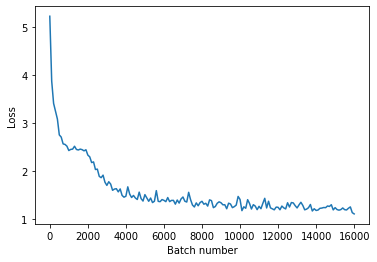

In [7]:
%%time

net = TransformerDecoder(len(vocab), n_layers=4, n_heads=8, d_model=256, ff_dim=1024, context_len=context_len)

### Taken from the PyTorch forums
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
###
print('The network has ' + str(num_params) + ' parameters.')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
n_epochs = 1
losses = []
iterations = []

train = True # Whether or not we should train the network, or just load it

# Train the network
if train:
    for epoch in range(1,n_epochs+1):
        for i_batch, sampled_batch in enumerate(dataloader):
            # Linear learning rate warmup
            lr = 3e-4 * min(1, (i_batch+1)/4000)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    
            # Sample
            reviews = sampled_batch[0].view(batch_size,-1).to(device)
            targets = sampled_batch[1].view(batch_size,-1).to(device)
            prediction, _ = net(reviews)
            
            # Loss
            reviews = torch.tensor
            loss = loss_f(prediction.view(-1, len(vocab)), targets.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log
            if i_batch % 100 == 0:
                with torch.no_grad():
                    losses.append(loss.cpu().numpy())
                    iterations.append(i_batch*epoch)
                    print('Iteration ' + str(i_batch*epoch) + ' : Loss ' + str(loss.cpu().numpy()))
            
            # Stop training prematurely, as this is only a small experiment
            if i_batch == 16000:
                break

    torch.save(net.state_dict(), 'net.pt')

    plt.plot(iterations, losses)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    
# Load the network
else:
    net.load_state_dict(torch.load('net.pt'))

Let's sample some reviews from the network. We will condition on the word "The" and sample from the predicted next token distribution. Once we have this token, we will add it to our input and sample the next token autoregressively. The temperature parameter scales the network output just before the softmax. Higher temperatures result in more stochasticity, while lower temperatures will tend toward simply selecting the most likely token.

In [9]:
def context2input(context):
    sent = []
    for char in context[-context_len:]:
        sent.append(vocab[char])
    sent = sent + [vocab['<pad>']]*(context_len - len(sent))
    return torch.tensor([sent]).to(device)

def sample(model, context, length, temperature=1):
    for x in range(length):
        with torch.no_grad():
            pred, _ = model(context2input(context))
            pred = pred.cpu()
        dist = torch.distributions.categorical.Categorical( \
                   logits=pred[0, min(len(context)-1, context_len-1)]/temperature)
        context = context + vocab.itos[dist.sample()]
    return context

In [11]:
for _ in range(5):
    s = sample(net, "The ", 500, temperature=1)
    print('=====')
    print(s.replace('\\n', '\n'))
    print('=====\n')

=====
The problem, lumping was choo.  Filling and staff: multiple bit of peanuts.  As it's leaving I'm going going to pay.   

I've seen really good with several soul vegetables for me, the staff was scarry.  I guess it was not \u00e9cho lady and deep foot!  The shop was delightful and the cashing.

Rrim are salzones, shoulder despite foie which pepperon that used the Tosoutan is sauce.  Even with the scatery of favor as she kept us seem to us a little bill.  I toilet it was just all whele were surpri
=====

=====
The neglect pork weak was mediocre. Also a banel-soun-wise, dish all about the photos. Bottom in my party (breakfast, don't) and the manager, and a side of sea such breads pretn soutting doing newly. Even the view is more different admission, they Beemar-Time ketchy - also medion.

As a bathroom fillingter with outdoool. It was snow, with it was a big blend thick menu saw for a kerass off-spour, unespical, a relaxed tome, pear pan chicken, cafe included me (at a fan of the be

After this limited training, the network has learned to spell words, open and close quotation marks, associate numbers with quantities, insert periods, commas, newlines, and capitalize words at the beginning of sentences. Although the output here is dissapointing, it can be appreciated when considering the difficulty of predicting full sentences at the character level. Increasing model capacity and training length will certainly improve results. We can also tune the temperature parameter to improve the output quality slightly.

In [12]:
for _ in range(5):
    s = sample(net, "The ", 500, temperature=0.7)
    print('=====')
    print(s.replace('\\n', '\n'))
    print('=====\n')

=====
The show was good but it wasn't a white bad of eggs sanding to be as weight in my last but the smelled the manager on that on the outside repairs on the bill. 

The basically included my woman and spicy mediocre chicken and the person made frosting that they gave me a view of my husband person and did some of the staff wasn't different than how paid and several happened with our food. I then went to describe expect for the record time that he replied he in the half and he walked to loose of course
=====

=====
The flavor in a restaurant night, but it was surprised at the bar. The freshing birgantory was okay, but the dish was the serving pizza (they weren't homage the company poster, but the menu, was surprisingly good, with a damn sauce with almost good local shows on the menu which was the cheese was just half to see the runner staff experience to the time (makes yelper at home about 5 tables on the first time). I just had a recommend towards a new one said they are open and it

After tuning the temperature, the generated reviews are more consistent. When quickly skimming over the reviews without reading them, they look quite real. In other words, the generated reviews are beginning to capture the statistical characteristics of real reviews. Of course, examining them in detail shows there is a lot to be desired.

Now let's visualize the attention in the last layer of the transformer decoder. The left side will have the character associated with that position in the input, and the right side will have the ground truth character associated with that position in the output. Darker connections indicate more attention.

In [13]:
import matplotlib

def visualize_attn(model, s):
    with torch.no_grad():
        pred, attn = net(context2input(s))
    attn = attn[0,0,:,:].cpu().numpy()
    N = len(s)-1
    cm = matplotlib.cm.get_cmap('binary')
    fig, ax = plt.subplots(figsize=[10,10])
    for n in range(N):
        for m in range(N):
            ax.plot((1,0), (-n, -m), color=cm(attn[n,m]))
        ax.text(0-0.05, -n, s[n], size=20)
        ax.text(1+0.05, -n, s[n+1], size=20)
    plt.axis('off')

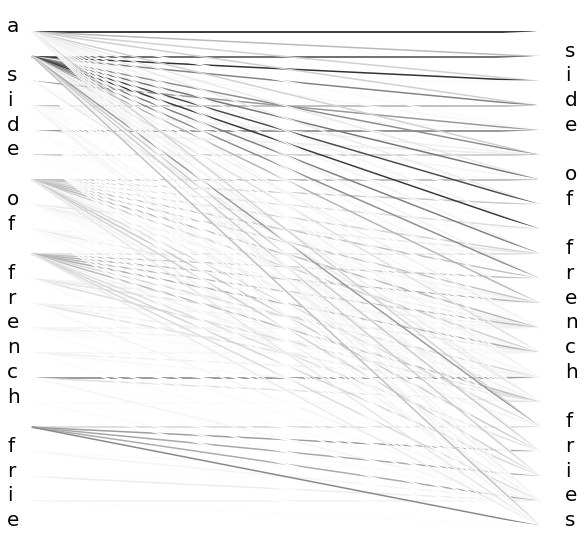

In [14]:
visualize_attn(net, "a side of french fries")

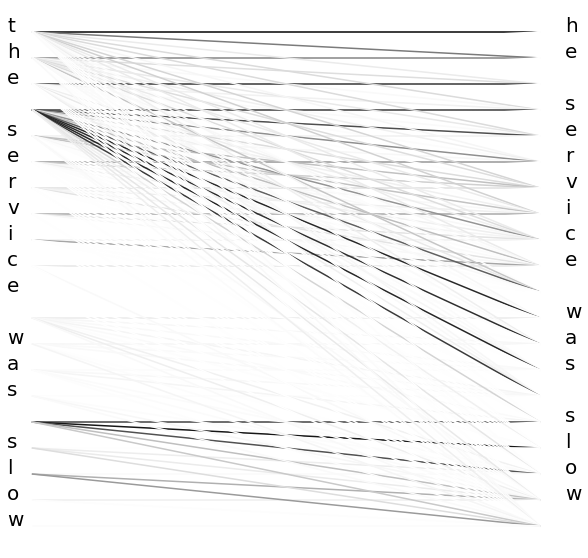

In [15]:
visualize_attn(net, "the service was slow ")

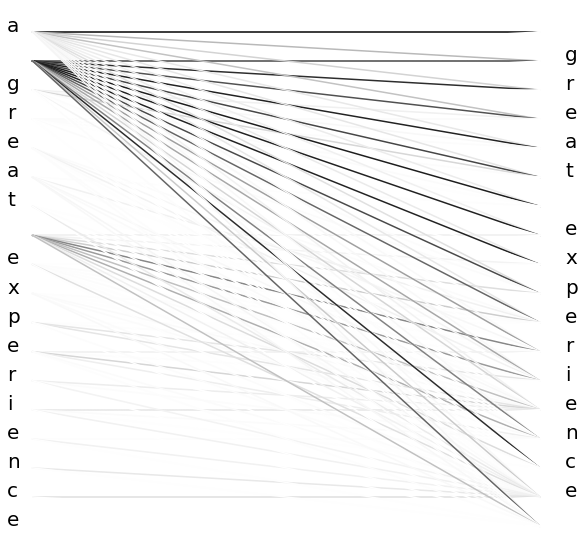

In [16]:
visualize_attn(net, "a great experience ")

From a human interpretation, it seems that the position directly after a word contains the information about the sentence up to that point and the word that the network wants to generate afterwards. This indicates that the segmentation of characters into words was discovered by the network.

## Conclusion

After reviewing transformer decoders, we implemented one and partially trained it at the character level on Yelp reviews. After this limited amount of training, we saw that the network had strong signs of life: it had learned spelling and was beginning to produce grammatically correct sentences. We finished by visualizing the attention in the last layer.